# **Differential expression analysis from publically-available RNAseq data**

## Goals
1. Introduction to publically-available RNAseq data.
2. Understanding the importance of metadata when using publically-available data and tools.
3. Data wrangling for the use of open source tools.
4. Use of Bioconductor tools through a real-world question.

## Prerequisites
- A working knowledge of R although the written code is intended to be as simple as possible for clarity.



## RNAseq
This is not intended to be a comprehensive explanation of RNAseq analysis, but by the end of this module you will have completed a simple Group A vs. Group B differential expression analysis using publically-available RNAseq data derived from [The Cancer Genome Atlas](https://cancergenome.nih.gov/), [reanalyzed to remove computational batch effects](https://www.nature.com/articles/nbt.3772), and [deposited for use](https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN). This module also is a single example of how to do this analysis, but many different pipelines have been developed to give similar results. [Conesa et. al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4728800/) published a fairly comprehensive review of RNAseq best practices and other groups have compared the effectiveness of different pipelines, such as [Soneson et al.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-91) and [Teng et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4842274/)

For a brief introduction to RNAseq, watch the first **8 minutes** of this video created by Josh Starmer at UNC. 

[![RNAseq intro](http://img.youtube.com/vi/tlf6wYJrwKY/0.jpg)](https://www.youtube.com/watch?v=tlf6wYJrwKY)


# How is RNAseq data publically-available? Isn't that a HIPPA violation?
Great question. The publication of sequence alignments would be a HIPPA violation. However, there are several ways of analyzing RNAseq data and they do not all result in raw reads or alignment files.

## *De Novo Assembly*
- Typically used when a reference genome/transcriptome is unavailable or unreliable.
- Extremely computationally intensive.
- Results contain sequence information in alignment form (.bam)
- Ex. [Trinity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3875132/)



## Referenced-based Assembly

#### **Alignment-based**
- Can only be used when a reference genome/transcriptome is available.
- Computationally intensive, but not as much so as *de novo* assembly
- Results contain sequence information in alignment form (.bam)
- Some alignment based methods such as Tophat and HiSat2 can detect novel genes/isoforms.
- Mutation/editing events can be called from alignment file.
- Exs. [Tophat2](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-4-r36) and [HiSat2](https://ccb.jhu.edu/software/hisat2/index.shtml)
    
#### **Alignment-free**
- Requires a reference transcriptome.
- Orders of magnitude faster than alignment-based methods.
- **Resulting file does not contain sequence information**, but rather the number of reads (counts) of each transcript/gene.
- Cannot detect novel genes/isoforms.
- Exs. [Kallisto](https://www.nature.com/articles/nbt.3519) and [Salmon](https://www.nature.com/articles/nmeth.4197).







# Where can I find publically-available alignment-free RNAseq data?
Some authors choose to publish the files in the supplementary information with their papers, other deposit files into [GEO](https://www.ncbi.nlm.nih.gov/gds), and others have it hosted by browsers such as the [XENA Browser](https://xenabrowser.net/datapages/). The data that you will use in this module is counts data from [The Cancer Genome Atlas](https://cancergenome.nih.gov/). 

## TCGA
The goal of the TCGA was to understand all of the changes that lead to the formation of cancer. See the image below for details about the type and amount data generated and some of the general findings.
![TCGA](https://cancergenome.nih.gov/PublishedContent/Images/images/tcga-infographic-enlarge.__v100169753.png "TCGA")







## Encyclopedia of DNA Elements (ENCODE)

The original TCGA data was analyzed years ago using alignment-based approachs with a transcriptome file that only included ~20,000 genes. In the years since the original publication of the data, our understanding of the transcriptome has increased with large genomic studies such as [ENCODE](https://www.encodeproject.org/), which is also a repository of publically-available genomic data. ![ENCODE](https://www.encodeproject.org/static/img/classic-image.jpg "ENCODE") 

The results of ENCODE suggested that ~80% of the genome is functional and that there are closer to 60,000 genes than 20,000. Most of the other genes discovered were non-coding genes, meaning the functioning unit is the RNA rather than the RNA serving only as a meassage to make protein. That means if used the [publically-available TCGA data](https://gdac.broadinstitute.org/) than we would only be analzing 1/3 of the possible data. However, it would be unreasonable for us to reanalyze all of the TCGA data (it would cost ~$800,000 in compute time) and because it is referenced-based it would contain identifiable information, meaning we would need a data use agreement to do so. Fortunately, all of TCGA data was [reanalyzed](https://www.nature.com/articles/nbt.3772) with a newer genome annotation file that includes ~60,000 genes and ~200,000 transcripts. We will use this data that is available at from the [XENA Browser](https://xenabrowser.net/datapages/), which hosts over 1500 publically-available datasets.  

# The question that we will answer
## What are the differentially expressed genes between HER2 positive and Triple-Negative Breast Cancer (TNBC)?
Breast cancer is a classic example of the use of precision treatment. Patients with cancerous cells that express the estrogen receptor (ER+) receive hormone therapy and a recent [report](https://www.ncbi.nlm.nih.gov/pubmed/29860917?dopt=Abstract) demonstrates that a subset of those patients based entirely on gene expression do not benefit from chemotherapy. Likewise, patients with cancerous cells with amplified ERBB2 (HER2) are treated with a targeted therapy that has dramatically improved the prognosis of those patients. However, patients with breast cancer cells that do not express ER, HER2, or the progesteron receptor (PR) have what is known as triple-negative breast cancer (TNBC). There are currently no targeted therapies for TNBC breast cancer. One might be interested in what genes are expressed differently in HER2+ vs. TNBC given that HER2+ are typically also ER and PR negative. We will ask that question using the TCGA counts data. 



## Our pipeline
In the pipeline image, the red text indicates the names of the R packages we will use to perform the analysis, the yellow boxes indicate the data (raw or processed), and the grey indicates what we will do in each step. Note that we will use [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) to identify differentially expressed genes (DEGs). This is a highly cited package that uses a negative binomial distribution to calculate DEGs. However, there are multiple pipelines and programs to do this. [Knoweng](http://education.knoweng.org/sequenceng/) has a nice interface to explore other options, including the strengths and weaknesses of each.
![](https://github.com/davidnboone/test-image/blob/master/overview-image.jpg?raw=true "pipeline overview")

# Let's get started by Installing and loading the necessary R packages
Only run the code below if you have not previously installed these packages


In [157]:
#you can very easily use "install.packages" or "biocLite" to install the packages and "library" to load them
#however, instead I am installing a package called pacman that will determine if a package is already installed
#if it is not it will install it and after will load it
#this method is convenient when sharing code that requires the use of others packages

if (!require("pacman")) install.packages("pacman")
pacman::p_load(R.utils, data.table, tximport, DESeq2, biomaRt, jsonlite, BiocParallel, ggplot2, gplots, RColorBrewer, devtools)


# Setup a workspace
I like to create a project name as the parent directory with subdirectories to hold the downloaded raw and metadata. I then will create other subdirectories by date to host all of the analyses.


In [ ]:
project_name <- "TCGA_Her2_TNBC_DEGs"
date <- "2018_08_28"
dir.create(file.path(project_name, "raw_data"), recursive = TRUE)
dir.create(file.path(project_name, "metadata"), recursive = TRUE)
dir.create(file.path(project_name, date), recursive = TRUE)
setwd(project_name)


# Reproducibilty is only possible if we know the correct version of all the software and data. R has a built in function sissionInfo() that will print all of the versions of the packages and R itself. It is critical to record this metadata with your analyses. 

In [170]:
#check that all of the packages loaded
sessionInfo()

#save that info to file
#the sink command saves all info that is normally printed to screen
sink(file.path(date, "raw_data", "analysis.package.versions.txt"))
sessionInfo()
sink()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] devtools_1.13.6            RColorBrewer_1.1-2        
 [3] gplots_3.0.1               ggplot2_2.2.1             
 [5] BiocParallel_1.8.2         jsonlite_1.5              
 [7] biomaRt_2.30.0             DESeq2_1.14.1             
 [9] SummarizedExperiment_1.4.0 Biobase_2.34.0            
[11] GenomicRanges_1.26.4       GenomeInfoDb_1.10.3       
[13] IRanges_2.8.2              

Warning message in file(file, if (append) "a" else "w"):
“cannot open file '2018_08_28/analysis.package.versions.txt': No such file or directory”

ERROR: Error in file(file, if (append) "a" else "w"): cannot open the connection


# Download and decompress the data
Note we are downloading the count data and abumdance data (tpm)from the [TCGA pancan analysis](https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN) on the XENA browser because this contains all of the reanalyzed TCGA data. However, for the clinical data we will download directly from the [breast cancer dataset](https://xenabrowser.net/datapages/?cohort=TCGA%20Breast%20Cancer%20(BRCA) also hosted on the XENA Browser. This is because much of the clinical data is not retained in the pancan phenotype data because every cancer type has different clinical tests that are unique.

In [20]:
#clinical data downloaded from 
download.file(url = "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix.gz", destfile = "./raw_data/tcga_brca.clinical")
download.file(url = "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix.json", destfile = "./metadata/tcga_brca.clinical.metadata")


#download TCGA count data this is pancan
download.file(url = "https://toil.xenahubs.net/download/tcga_Kallisto_est_counts.gz", destfile = "./raw_data/tcga_countdata.gz")
download.file(url = "https://toil.xenahubs.net/download/tcga_Kallisto_est_counts.json", destfile = "./metadata/tcga_count_metadata")

#download TCGA TPM data this is pancan
download.file(url = "https://toil.xenahubs.net/download/tcga_Kallisto_tpm.gz", destfile = "./raw_data/tcga_tpmdata.gz")
download.file(url = "https://toil.xenahubs.net/download/tcga_Kallisto_tpm.json", destfile = "./metadata/tcga_tpm_metadata")


#the counts and TPM data are compressed files so we will use the R.utils function gunzip to decompress
gunzip("./raw_data/tcga_countdata.gz")
gunzip("./raw_data/tcga_tpmdata.gz")


# Confirm the files were downloaded and extracted
Run the command below to confirm that the files downloaded into the proper directories and were decompressed. Also, this will show you the full names of the files that you will use later in this exercise. 

In [1]:
#look to see that files downloaded and extracted. Also determine the path for the appropriate clinical file
list.files(recursive = TRUE)
           


[1] "TCGA_Her2_DEGs/2018_03_29/2018_03_29_TCGA_brca_her2_staus_final.txt"                                                                                               
 [2] "TCGA_Her2_DEGs/2018_03_29/brca.her2.known.counts.Rda"                                                                                                              
 [3] "TCGA_Her2_DEGs/2018_03_29/brca.untran.gene.counts.Rda"                                                                                                             
 [4] "TCGA_Her2_DEGs/2018_03_29/df.unlogcounts_her2_bc.Rda"                                                                                                              
 [5] "TCGA_Her2_DEGs/2018_03_29/her2.dds.data.Rda"                                                                                                                       
 [6] "TCGA_Her2_DEGs/2018_03_29/her2.deseq.data.Rda"                                                                                                                     
 [7] "TCGA_Her2_DEGs/2018_03_29/metadata/genemapping_metadata"                                                                                                           
 [8] "TCGA_Her2_DEGs/2018_03_29/metadata/tcga_count_metadata"                                                                                                            
 [9] "TCGA_Her2_DEGs/2018_03_29/raw_data/brca_clin_data2/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0/BRCA.clin.merged.txt"                        
[10] "TCGA_Her2_DEGs/2018_03_29/raw_data/brca_clin_data2/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0/BRCA.merged_only_biospecimen_clin_format.txt"
[11] "TCGA_Her2_DEGs/2018_03_29/raw_data/brca_clin_data2/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0/BRCA.merged_only_clinical_clin_format.txt"   
[12] "TCGA_Her2_DEGs/2018_03_29/raw_data/brca_clin_data2/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0/BRCA.merged_only_omf_clin_format.txt"        
[13] "TCGA_Her2_DEGs/2018_03_29/raw_data/brca_clin_data2/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0/MANIFEST.txt"                                
[14] "TCGA_Her2_DEGs/2018_03_29/raw_data/BRCA.TCGA.Firehose.clin.data.tar.gz"                                                                                            
[15] "TCGA_Her2_DEGs/2018_03_29/raw_data/gencode.v23.annotation.gtf"                                                                                                     
[16] "TCGA_Her2_DEGs/2018_03_29/raw_data/tcga_countdata"                                                                                                                 
[17] "TCGA_Her2_DEGs/2018_03_29/tx2gene_xena.Rda"                                                                                                                        
[18] "TCGA_Her2_TNBC_DEGs/2018_06_27/brca.clin.data.her2.tnbc.txt"                                                                                                       
[19] "TCGA_Her2_TNBC_DEGs/2018_06_27/brca.untran.gene.counts.Rda"                                                                                                        
[20] "TCGA_Her2_TNBC_DEGs/brca.her2.known.counts.Rda"                                                                                                                    
[21] "TCGA_Her2_TNBC_DEGs/df.unlogcounts_her2_bc.Rda"                                                                                                                    
[22] "TCGA_Her2_TNBC_DEGs/metadata/genemapping_metadata"                                                                                                                 
[23] "TCGA_Her2_TNBC_DEGs/metadata/tcga_brca.clinical.metadata"                                                                                                          
[24] "TCGA_Her2_TNBC_DEGs/metadata/tcga_count_metadata"                                    

# Start the analysis
The first step in our pipeline above is to wrangle and merge the clinical and counts data to determine which counts data are from TNBC tumors and which are from HER2+ tumors. 

### TCGA Barcode
To do this, first we must understand, which patient IDs refer to tumors that are HER2+ and TNBC. To do that we must look at the clinical data and must understand the TCGA Barcode. ![TCGA barcode](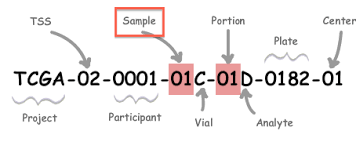 "barcode")
The definitions of each of the components include what the samples are is found [here](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes). For our purposes we will focus on the first 12 alphanumeric digits of this code. "TCGA-XX-XXXX-XX". The first 6 Xs provide an anonymous identifier unique to each patient. The final 2 Xs define what type of sample it is. For the breast cancer data that we downloaded there are only three codes, "-01" is a solid tumor, "-06" is a metastatic tumor, and "-11" is normal solid tissue. For asking what are the difference between TNBC and HER2+ cancers, we will primarily be interested in the samples with "-01" as these are primary tumors. We also need to know if the tumors are TNBC or HER2+. We can infer this based on the clinical data.

### Defining HER2+ and TNBC tumors
Read in the clinical data and examine it by running the code below.

In [5]:

# Read clinical data. Note from experience I know that there are both NAs and blank spaces. The na.strings = c("", "NA") command will force both to be NAs in the dataframe
brca.clin.data <- read.delim("./raw_data/tcga_brca.clinical", header = TRUE, stringsAsFactors = FALSE, na.strings = c("","NA"))
head(brca.clin.data)


sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,⋯,X_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_data.public.TCGA.BRCA.miRNA_GA_gene,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_data.public.TCGA.BRCA.miRNA_HiSeq_gene,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2,X_GENOMIC_ID_TCGA_BRCA_PDMarray
TCGA-3C-AAAU-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,6ef883fc-81f3-4089-95e0-86904ffc0d38,NA,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NA,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NA
TCGA-3C-AALI-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NA,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NA,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NA
TCGA-3C-AALJ-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,c924c2a8-ab41-4499-bb30-79705cc17d45,NA,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NA,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NA
TCGA-3C-AALK-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1a19e068-d213-41ef-aebb-104017a883cc,NA,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NA,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NA
TCGA-4H-AAAK-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,2ea9e472-a408-4ae0-975d-50a566f22b2a,NA,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NA,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NA
TCGA-5L-AAT0-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,32e61645-eb89-49f7-9876-85b1497c7e42,NA,TCGA-5L-AAT0-01A-12D-A41E-01,TCGA-5L-AAT0-01,NA,32e61645-eb89-49f7-9876-85b1497c7e42,TCGA-5L-AAT0-01A-12D-A41E-01,NA


The table is set up so that patients (notice the TCGA barcode) are listed as rows and clinical features as columns. We need to see a list of all clinical features by examing the column names.

In [6]:
colnames(brca.clin.data)

[1] "sampleID"                                                        
  [2] "AJCC_Stage_nature2012"                                           
  [3] "Age_at_Initial_Pathologic_Diagnosis_nature2012"                  
  [4] "CN_Clusters_nature2012"                                          
  [5] "Converted_Stage_nature2012"                                      
  [6] "Days_to_Date_of_Last_Contact_nature2012"                         
  [7] "Days_to_date_of_Death_nature2012"                                
  [8] "ER_Status_nature2012"                                            
  [9] "Gender_nature2012"                                               
 [10] "HER2_Final_Status_nature2012"                                    
 [11] "Integrated_Clusters_no_exp__nature2012"                          
 [12] "Integrated_Clusters_unsup_exp__nature2012"                       
 [13] "Integrated_Clusters_with_PAM50__nature2012"                      
 [14] "Metastasis_Coded_nature2012"                                     
 [15] "Metastasis_nature2012"                                           
 [16] "Node_Coded_nature2012"                                           
 [17] "Node_nature2012"                                                 
 [18] "OS_Time_nature2012"                                              
 [19] "OS_event_nature2012"                                             
 [20] "PAM50Call_RNAseq"                                                
 [21] "PAM50_mRNA_nature2012"                                           
 [22] "PR_Status_nature2012"                                            
 [23] "RPPA_Clusters_nature2012"                                        
 [24] "SigClust_Intrinsic_mRNA_nature2012"                              
 [25] "SigClust_Unsupervised_mRNA_nature2012"                           
 [26] "Survival_Data_Form_nature2012"                                   
 [27] "Tumor_T1_Coded_nature2012"                                       
 [28] "Tumor_nature2012"                                                
 [29] "Vital_Status_nature2012"                                         
 [30] "X_EVENT"                                                         
 [31] "X_INTEGRATION"                                                   
 [32] "OS.time"                                                         
 [33] "OS"                                                              
 [34] "OS.unit"                                                         
 [35] "X_PANCAN_CNA_PANCAN_K8"                                          
 [36] "X_PANCAN_Cluster_Cluster_PANCAN"                                 
 [37] "X_PANCAN_DNAMethyl_BRCA"                                         
 [38] "X_PANCAN_DNAMethyl_PANCAN"                                       
 [39] "X_PANCAN_RPPA_PANCAN_K8"                                         
 [40] "X_PANCAN_UNC_RNAseq_PANCAN_K16"                                  
 [41] "X_PANCAN_miRNA_PANCAN"                                           
 [42] "X_PANCAN_mirna_BRCA"                                             
 [43] "X_PANCAN_mutation_PANCAN"                                        
 [44] "X_PATIENT"                                                       
 [45] "RFS.time"                                                        
 [46] "RFS"                                                             
 [47] "RFS.unit"                                                        
 [48] "X_TIME_TO_EVENT"                                                 
 [49] "X_TIME_TO_EVENT_UNIT"                                            
 [50] "X_cohort"                                                        
 [51] "X_primary_disease"                                               
 [52] "X_primary_site"                                                  
 [53] "additional_pharmaceutical_therapy"                               
 [54] "additional_radiation_therapy"                                    
 [55] "additional_surgery_locoregional_procedure"           

### Where are HER2 and TNBC statuses?
To determine TNBC we need to know if each tumor is positive or negative for estrogen receptor (ER), progesterone receptor (PR), and HER2. ER is determined by immunohistochemistry (IHC) and is directly reported for all patients under "breast_carcinoma_estrogen_receptor_status." PR is determined by immunohistochemistry and is directly reported for all patients under "breast_carcinoma_progesterone_receptor_status." However, HER2 is not directly reported for each patient. Instead, HER2 is determined clinically by two different tests (IHC and in situ hybridization) that are reported (if available) under "lab_proc_her2_neu_immunohistochemistry_receptor_status" and "lab_procedure_her2_neu_in_situ_hybrid_outcome_type." Often IHC is performed first and if an indeterminable result is obtained then in situ hybridization is performed. However, if you examine the data closely you will notice that in some instances IHC and in situ hybridization will be discordant. We will throw out those samples for our analysis as we cannot properly determine HER2 status. Otherwise if one of the two tests has a "positive" or "negative" result and the other test is NA or indeterminable, we will use the single test result. Run the code below to select only the columns that we are interested in using as well as to determine the HER2 status based on the two tests. Note that we replace NAs to 0s to make execution easier. Also, we define HER2-negative as 0, HER2-postive as 1, and HER2-indeterminate as 2.

In [7]:
#code to pull out ER and PR final statuses and HER2 tests used to calculuate HER2 final status to make the clinical data easier to work with
brca.clin.selected <- brca.clin.data[, c("sampleID", "breast_carcinoma_estrogen_receptor_status", "breast_carcinoma_progesterone_receptor_status", "lab_proc_her2_neu_immunohistochemistry_receptor_status", "lab_procedure_her2_neu_in_situ_hybrid_outcome_type")]

#set NAs to 0 to allow for easier logic in following steps
brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status[is.na(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status)] <- 0
brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type[is.na(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type)] <- 0

# 0 = negative; 1 = positive; 2 = unknown or discordant
brca.clin.selected$HER2 <- ifelse(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status == "Positive" &
                                    brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type != "Negative", 1,
                                  ifelse(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type == "Positive" &
                                           brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status != "Negative", 1,
                                         ifelse(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status == "Negative" &
                                                  brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type != "Positive", 0,
                                                ifelse(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type == "Negative" &
                                                         brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status != "Positive", 0, 2))))


### Check the logic
Let's check that it worked in two different ways: 
1. spot checking the logic by looking directly at the table.
2. calculating the percent of samples that are HER2+, which should be ~15-20%

In [8]:
head(brca.clin.selected)

#calculate number of HER2 pos, neg, and unknowns
num.her2.negi <- nrow(brca.clin.selected[brca.clin.selected$HER2 == 0, ])
num.her2.posi <- nrow(brca.clin.selected[brca.clin.selected$HER2 == 1, ])
num.her2.unko <- nrow(brca.clin.selected[brca.clin.selected$HER2 == 2, ])
percent.her2.posi <- 100* num.her2.posi / (num.her2.negi + num.her2.posi)

num.her2.negi
num.her2.posi
num.her2.unko
percent.her2.posi


sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type,HER2
TCGA-3C-AAAU-01,Positive,Positive,Negative,0,0
TCGA-3C-AALI-01,Positive,Positive,Positive,0,1
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,0,2
TCGA-3C-AALK-01,Positive,Positive,Positive,0,1
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,0,2
TCGA-5L-AAT0-01,Positive,Positive,Negative,0,0


[1] 857

[1] 206

[1] 184

[1] 19.37912

### Now you write the logic to determine if each sample is TNBC or not.
Note, if a sample is TNBC then ER, PR, **AND**, HER2 must all be negative. If any of them are positive, then they are not TNBC. There also will be some that we cannot determine because the known ER, PR, and HER2 will be negative, but at least one of the three is unknown. Store the values in a column named "TNBC" in the brca.clin.selected data frame. Have "0" indicicate that the sample is NOT_TNBC, "1" indicate that the sample is TNBC, and "2" mean it is unclear with the given data.

**Hint** be sure to change ER and PR NAs to 0s to make the logic easier like in the code above. The results should indicate that 176 samples are TNBC and 973 are not.

In [9]:
brca.clin.selected$breast_carcinoma_estrogen_receptor_status[is.na(brca.clin.selected$breast_carcinoma_estrogen_receptor_status)] <- 0
brca.clin.selected$breast_carcinoma_progesterone_receptor_status[is.na(brca.clin.selected$breast_carcinoma_progesterone_receptor_status)] <- 0

brca.clin.selected$TNBC <- 

nrow(brca.clin.selected[brca.clin.selected$TNBC == 1, ])
nrow(brca.clin.selected[brca.clin.selected$TNBC == 0, ])


[1] 176

[1] 973

### Save the clinical data table with the generated feature into the dated directory

In [10]:
#write clinical table with HER2 and TNBC features in analysis directory (date) so we can just load later instead of running the above code
write.table(brca.clin.selected, file = file.path(date, "brca.clin.data.her2.tnbc.txt"))

# Read TCGA count data and parse for only HER2+ and TNBC Breast Cancer data
The downloaded data contains counts from ~197,000 transcripts across ~10,500 samples resulting in a nearly 15GB file. Simply reading this file using base R would require more RAM than your personal computer likely has, so instead we will use the fread function with the select command in the data.table package to only read the breast cancer data (both counts and tpm) that we are interested in exploring. fread is also much faster than read.table.

In [46]:
###################################################################################################################
######################### read counts data and parse only BRCA data ###############
###################################################################################################################


#note fread with selected columns is required because total tcga count file is too large to read into RAM
#the columns selected are those of breast cancer samples with both clinical and counts data
#fread can also not handle duplicates so those must be removed see the dups<- line

#this line reads the first 10 rows of the entire tcga counts data. This is used to find BRCA sample names and duplicates for fread
head.tcga.counts <- fread("./raw_data/tcga_countdata", nrows = 10)

#lets look at these 10 rows
head.tcga.counts

#and compare the BRCA TCGA IDs from the clinical data
head(brca.clin.selected)




sample,TCGA-E9-A1N3-01,TCGA-EL-A3ZP-01,TCGA-E2-A152-01,TCGA-66-2734-01,TCGA-BQ-5885-01,TCGA-E2-A15T-01,TCGA-ZB-A96R-01,TCGA-DT-5265-01,TCGA-IF-A3RQ-01,⋯,TCGA-AB-2965-03,TCGA-AB-2936-03,TCGA-AB-2839-03,TCGA-AB-2879-03,TCGA-AB-2886-03,TCGA-AB-2901-03,TCGA-AB-2862-03,TCGA-AB-2956-03,TCGA-AB-2987-03,TCGA-AB-2868-03
ENST00000548312.5,4.1388,4.7794,2.4952,3.9292,2.5951,4.7885,2.9531,3.5097,2.8419,⋯,4.9198,4.3081,3.9424,3.7138,2.9956,3.7102,5.3495,5.9889,5.3384,2.5848
ENST00000527779.1,0.0000,5.1012,3.1961,6.1152,0.0000,1.6794,0.0000,0.0000,0.0000,⋯,2.4758,4.0959,0.0000,0.0000,0.0000,0.0000,0.0000,0.0010,0.0000,0.0000
ENST00000454820.5,0.0000,0.0000,3.1100,0.0000,0.0000,0.0000,3.8304,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000535093.1,5.5617,2.6526,1.9545,2.2700,2.0439,0.0000,0.0000,0.0000,0.0000,⋯,6.3089,7.6301,6.9374,6.5287,6.8146,6.5550,5.3162,4.0364,5.9004,5.8837
ENST00000346219.7,0.1113,7.2602,2.2507,3.6439,0.0000,2.6988,2.7492,0.0000,0.0000,⋯,0.0000,0.2372,0.0000,4.9439,0.0000,3.9337,0.0000,0.0000,0.0000,5.1689
ENST00000570899.1,1.9184,2.8842,1.9044,1.9167,1.5186,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,2.6503,0.0000,3.4753,2.3618,2.0097,2.8518,0.0000,3.1705,0.0000
ENST00000557761.1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3219,0.0000,0.0000,⋯,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000625998.2,8.8211,9.7346,0.0000,5.7186,9.8577,8.8328,9.4838,9.4309,7.1453,⋯,8.2499,9.5533,9.0677,9.3293,7.9303,8.4175,8.7682,7.7707,6.3089,7.7554
ENST00000583693.5,6.1047,7.6215,4.8872,6.7369,6.6153,5.9735,6.1458,7.6051,6.6566,⋯,6.4934,8.7063,7.4456,8.0960,9.0860,7.9271,8.4432,8.4766,7.4823,8.0912
ENST00000383738.6,2.2149,1.5032,2.9904,2.3574,0.0000,3.9607,0.0000,3.4029,2.2029,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.3081,0.0000,0.0000


sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type,HER2,TNBC
TCGA-3C-AAAU-01,Positive,Positive,Negative,0,0,0
TCGA-3C-AALI-01,Positive,Positive,Positive,0,1,0
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,0,2,0
TCGA-3C-AALK-01,Positive,Positive,Positive,0,1,0
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,0,2,0
TCGA-5L-AAT0-01,Positive,Positive,Negative,0,0,0


### We need to intersect the columns of the entire counts file with those of the BRCA clinical data to provide a list of IDs that is only from HER2+ and TNBC breast cancer
**note** If we compare the IDs we see they are in the same format with all uppercase letters and a hyphen seperating the sections of the ID. This is not always the case. Sometimes the IDs are writen tcga.xx.xxxx.xx. If that was the case, we would need to make them the same format before running the intersection command.

In [55]:
#the intersection of the clinical data samples and counts data is used because we only want counts data
#from samples with clinical data.
#note we add "sample" to the front because it is not in the names of brca.clin.selected but it is in tcga.counts (see above) 
#and we need that column to get transcript name in our final count file

#note we will only read data from samples that are either HER2+ or TNBC
#this command will find all samples that are HER2+ or TNBC AND have counts data
brca.counts.tnbc.her2.only <- c("sample", intersect(brca.clin.selected[brca.clin.selected$HER2 == 1 | brca.clin.selected$TNBC == 1, 1], colnames(head.tcga.counts)))

#this list contains tumors and normals. For this analysis, we will focus on tumors only
#tcga IDs define tumors with "-01" at the end of the ID and "-11" for normals
#we can use grep and the $ regexp to pull out only the tumors
#but don't forget that we need "sample" too!
brca.counts.tnbc.her2.tumors <- c("sample", brca.counts.tnbc.her2.only[grep("-01$", brca.counts.tnbc.her2.only)])

brca.counts.tnbc.her2.tumors
length(brca.counts.tnbc.her2.tumors)




[1] "sample"          "TCGA-3C-AALI-01" "TCGA-3C-AALK-01" "TCGA-A1-A0SK-01"
  [5] "TCGA-A1-A0SM-01" "TCGA-A1-A0SN-01" "TCGA-A1-A0SO-01" "TCGA-A1-A0SP-01"
  [9] "TCGA-A2-A04P-01" "TCGA-A2-A04Q-01" "TCGA-A2-A04T-01" "TCGA-A2-A04W-01"
 [13] "TCGA-A2-A04X-01" "TCGA-A2-A0CM-01" "TCGA-A2-A0CX-01" "TCGA-A2-A0D0-01"
 [17] "TCGA-A2-A0D1-01" "TCGA-A2-A0D2-01" "TCGA-A2-A0EY-01" "TCGA-A2-A0ST-01"
 [21] "TCGA-A2-A0SX-01" "TCGA-A2-A0SY-01" "TCGA-A2-A0T0-01" "TCGA-A2-A0T1-01"
 [25] "TCGA-A2-A0T2-01" "TCGA-A2-A0YE-01" "TCGA-A2-A0YG-01" "TCGA-A2-A0YM-01"
 [29] "TCGA-A2-A1G1-01" "TCGA-A2-A1G6-01" "TCGA-A2-A3XS-01" "TCGA-A2-A3XT-01"
 [33] "TCGA-A2-A3XU-01" "TCGA-A2-A3XV-01" "TCGA-A2-A3XX-01" "TCGA-A2-A3XY-01"
 [37] "TCGA-A2-A3XZ-01" "TCGA-A7-A0CE-01" "TCGA-A7-A0DA-01" "TCGA-A7-A26F-01"
 [41] "TCGA-A7-A26G-01" "TCGA-A7-A26H-01" "TCGA-A7-A26I-01" "TCGA-A7-A2KD-01"
 [45] "TCGA-A7-A4SD-01" "TCGA-A7-A4SE-01" "TCGA-A7-A4SF-01" "TCGA-A7-A5ZV-01"
 [49] "TCGA-A7-A6VV-01" "TCGA-A7-A6VW-01" "TCGA-A7-A6VY-01" "TCGA-A8-A06R-01"
 [53] "TCGA-A8-A06T-01" "TCGA-A8-A06U-01" "TCGA-A8-A06X-01" "TCGA-A8-A075-01"
 [57] "TCGA-A8-A076-01" "TCGA-A8-A07B-01" "TCGA-A8-A07C-01" "TCGA-A8-A07I-01"
 [61] "TCGA-A8-A07O-01" "TCGA-A8-A07P-01" "TCGA-A8-A07R-01" "TCGA-A8-A08B-01"
 [65] "TCGA-A8-A08C-01" "TCGA-A8-A08G-01" "TCGA-A8-A08H-01" "TCGA-A8-A08P-01"
 [69] "TCGA-A8-A08R-01" "TCGA-A8-A08S-01" "TCGA-A8-A08T-01" "TCGA-A8-A08X-01"
 [73] "TCGA-A8-A090-01" "TCGA-A8-A097-01" "TCGA-A8-A099-01" "TCGA-A8-A09E-01"
 [77] "TCGA-A8-A09G-01" "TCGA-A8-A09I-01" "TCGA-A8-A09N-01" "TCGA-A8-A09X-01"
 [81] "TCGA-A8-A0A7-01" "TCGA-A8-A0AB-01" "TCGA-AC-A23C-01" "TCGA-AC-A23G-01"
 [85] "TCGA-AC-A23H-01" "TCGA-AC-A2BK-01" "TCGA-AC-A2FB-01" "TCGA-AC-A2QH-01"
 [89] "TCGA-AC-A2QJ-01" "TCGA-AC-A3QQ-01" "TCGA-AC-A3TN-01" "TCGA-AC-A3W5-01"
 [93] "TCGA-AC-A3YI-01" "TCGA-AC-A4ZE-01" "TCGA-AC-A6IW-01" "TCGA-AC-A7VC-01"
 [97] "TCGA-AC-A8OS-01" "TCGA-AN-A03X-01" "TCGA-AN-A041-01" "TCGA-AN-A04C-01"
[101] "TCGA-AN-A04D-01" "TCGA-AN-A0AJ-01" "TCGA-AN-A0AK-01" "TCGA-AN-A0AL-01"
[105] "TCGA-AN-A0AR-01" "TCGA-AN-A0AT-01" "TCGA-AN-A0FD-01" "TCGA-AN-A0FJ-01"
[109] "TCGA-AN-A0FK-01" "TCGA-AN-A0FL-01" "TCGA-AN-A0FN-01" "TCGA-AN-A0FS-01"
[113] "TCGA-AN-A0FT-01" "TCGA-AN-A0FV-01" "TCGA-AN-A0FX-01" "TCGA-AN-A0FZ-01"
[117] "TCGA-AN-A0G0-01" "TCGA-AN-A0XP-01" "TCGA-AN-A0XU-01" "TCGA-AO-A03U-01"
[121] "TCGA-AO-A0J2-01" "TCGA-AO-A0J4-01" "TCGA-AO-A0J6-01" "TCGA-AO-A0JE-01"
[125] "TCGA-AO-A0JM-01" "TCGA-AO-A124-01" "TCGA-AO-A128-01" "TCGA-AO-A129-01"
[129] "TCGA-AO-A12D-01" "TCGA-AO-A12F-01" "TCGA-AO-A1KR-01" "TCGA-AQ-A04H-01"
[133] "TCGA-AQ-A04J-01" "TCGA-AQ-A04L-01" "TCGA-AQ-A0Y5-01" "TCGA-AQ-A1H2-01"
[137] "TCGA-AQ-A54N-01" "TCGA-AR-A0TQ-01" "TCGA-AR-A0TS-01" "TCGA-AR-A0TU-01"
[141] "TCGA-AR-A0TX-01" "TCGA-AR-A0U4-01" "TCGA-AR-A1AI-01" "TCGA-AR-A1AQ-01"
[145] "TCGA-AR-A1AR-01" "TCGA-AR-A1AT-01" "TCGA-AR-A1AX-01" "TCGA-AR-A1AY-01"
[149] "TCGA-AR-A24U-01" "TCGA-AR-A250-01" "TCGA-AR-A254-01" "TCGA-AR-A255-01"
[153] "TCGA-AR-A256-01" "TCGA-AR-A2LH-01" "TCGA-AR-A2LJ-01" "TCGA-AR-A2LR-01"
[157] "TCGA-AR-A5QN-01" "TCGA-AR-A5QQ-01" "TCGA-B6-A3ZX-01" "TCGA-B6-A400-01"
[161] "TCGA-B6-A402-01" "TCGA-B6-A409-01" "TCGA-BH-A0AV-01" "TCGA-BH-A0AW-01"
[165] "TCGA-BH-A0B3-01" "TCGA-BH-A0B4-01" "TCGA-BH-A0B6-01" "TCGA-BH-A0B7-01"
[169] "TCGA-BH-A0B9-01" "TCGA-BH-A0BG-01" "TCGA-BH-A0BL-01" "TCGA-BH-A0BQ-01"
[173] "TCGA-BH-A0BW-01" "TCGA-BH-A0C0-01" "TCGA-BH-A0C7-01" "TCGA-BH-A0DD-01"
[177] "TCGA-BH-A0DZ-01" "TCGA-BH-A0E0-01" "TCGA-BH-A0E6-01" "TCGA-BH-A0EE-01"
[181] "TCGA-BH-A0HY-01" "TCGA-BH-A0RX-01" "TCGA-BH-A0WA-01" "TCGA-BH-A18G-01"
[185] "TCGA-BH-A18H-01" "TCGA-BH-A18I-01" "TCGA-BH-A18M-01" "TCGA-BH-A18P-01"
[189] "TCGA-BH-A18R-01" "TCGA-BH-A18U-01" "TCGA-BH-A18V-01" "TCGA-BH-A1EN-01"
[193] "TCGA-BH-A1EV-01" "TCGA-BH-A1EW-01" "TCGA-BH-A1F2-01" "TCGA-BH-A1F6-01"
[197] "TCGA-BH-A1F8-01" "TCGA-BH-A1FC-01" "TCGA-BH-A202-01" "TCGA-BH-A42T-01"
[201] "TCGA-BH-A42U-01" "TCGA-C8-A12P-01" "TCGA-C8-A12Q-01" "TCGA-C8-A12T-01"
[205] "TCGA-C8-A12V-01" 

[1] 339

### Removing duplicates before fread
In the TCGA data a few samples had more than one section sequenced. This is indicated in the portion part of the TCGA ID code (see above). However, when reanlyzed the TCGA IDs were truncated, so the IDs are now duplicated when multiple sections of the same sample were sequenced. This will cause an error when using fread with the select command to choose the brca samples. Accordingly, we will proceed with the duplicates removed. Other functions can work with duplicates, but for the purpose of this exercise we will stick with the much faster fread.

In [56]:
#fread can also not handle duplicates so those must be removed
dups <- colnames(head.tcga.counts)[duplicated(colnames(head.tcga.counts))]
brca.samples.final <- setdiff(brca.counts.tnbc.her2.tumors, dups)
number_duplicates <- length(brca.counts.tnbc.her2.tumors) - length(brca.samples.final)
number_duplicates
brca.samples.final



[1] 4

[1] "sample"          "TCGA-3C-AALI-01" "TCGA-3C-AALK-01" "TCGA-A1-A0SK-01"
  [5] "TCGA-A1-A0SM-01" "TCGA-A1-A0SN-01" "TCGA-A1-A0SO-01" "TCGA-A1-A0SP-01"
  [9] "TCGA-A2-A04P-01" "TCGA-A2-A04Q-01" "TCGA-A2-A04T-01" "TCGA-A2-A04W-01"
 [13] "TCGA-A2-A04X-01" "TCGA-A2-A0CM-01" "TCGA-A2-A0CX-01" "TCGA-A2-A0D0-01"
 [17] "TCGA-A2-A0D1-01" "TCGA-A2-A0D2-01" "TCGA-A2-A0EY-01" "TCGA-A2-A0ST-01"
 [21] "TCGA-A2-A0SX-01" "TCGA-A2-A0SY-01" "TCGA-A2-A0T0-01" "TCGA-A2-A0T1-01"
 [25] "TCGA-A2-A0T2-01" "TCGA-A2-A0YE-01" "TCGA-A2-A0YG-01" "TCGA-A2-A0YM-01"
 [29] "TCGA-A2-A1G1-01" "TCGA-A2-A1G6-01" "TCGA-A2-A3XS-01" "TCGA-A2-A3XT-01"
 [33] "TCGA-A2-A3XU-01" "TCGA-A2-A3XV-01" "TCGA-A2-A3XX-01" "TCGA-A2-A3XY-01"
 [37] "TCGA-A2-A3XZ-01" "TCGA-A7-A0CE-01" "TCGA-A7-A0DA-01" "TCGA-A7-A26G-01"
 [41] "TCGA-A7-A26H-01" "TCGA-A7-A2KD-01" "TCGA-A7-A4SD-01" "TCGA-A7-A4SE-01"
 [45] "TCGA-A7-A4SF-01" "TCGA-A7-A5ZV-01" "TCGA-A7-A6VV-01" "TCGA-A7-A6VW-01"
 [49] "TCGA-A7-A6VY-01" "TCGA-A8-A06R-01" "TCGA-A8-A06T-01" "TCGA-A8-A06U-01"
 [53] "TCGA-A8-A06X-01" "TCGA-A8-A075-01" "TCGA-A8-A076-01" "TCGA-A8-A07B-01"
 [57] "TCGA-A8-A07C-01" "TCGA-A8-A07I-01" "TCGA-A8-A07O-01" "TCGA-A8-A07P-01"
 [61] "TCGA-A8-A07R-01" "TCGA-A8-A08B-01" "TCGA-A8-A08C-01" "TCGA-A8-A08G-01"
 [65] "TCGA-A8-A08H-01" "TCGA-A8-A08P-01" "TCGA-A8-A08R-01" "TCGA-A8-A08S-01"
 [69] "TCGA-A8-A08T-01" "TCGA-A8-A08X-01" "TCGA-A8-A090-01" "TCGA-A8-A097-01"
 [73] "TCGA-A8-A099-01" "TCGA-A8-A09E-01" "TCGA-A8-A09G-01" "TCGA-A8-A09I-01"
 [77] "TCGA-A8-A09N-01" "TCGA-A8-A09X-01" "TCGA-A8-A0A7-01" "TCGA-A8-A0AB-01"
 [81] "TCGA-AC-A23C-01" "TCGA-AC-A23G-01" "TCGA-AC-A23H-01" "TCGA-AC-A2BK-01"
 [85] "TCGA-AC-A2FB-01" "TCGA-AC-A2QJ-01" "TCGA-AC-A3TN-01" "TCGA-AC-A3W5-01"
 [89] "TCGA-AC-A3YI-01" "TCGA-AC-A4ZE-01" "TCGA-AC-A6IW-01" "TCGA-AC-A7VC-01"
 [93] "TCGA-AC-A8OS-01" "TCGA-AN-A03X-01" "TCGA-AN-A041-01" "TCGA-AN-A04C-01"
 [97] "TCGA-AN-A04D-01" "TCGA-AN-A0AJ-01" "TCGA-AN-A0AK-01" "TCGA-AN-A0AL-01"
[101] "TCGA-AN-A0AR-01" "TCGA-AN-A0AT-01" "TCGA-AN-A0FD-01" "TCGA-AN-A0FJ-01"
[105] "TCGA-AN-A0FK-01" "TCGA-AN-A0FL-01" "TCGA-AN-A0FN-01" "TCGA-AN-A0FS-01"
[109] "TCGA-AN-A0FT-01" "TCGA-AN-A0FV-01" "TCGA-AN-A0FX-01" "TCGA-AN-A0FZ-01"
[113] "TCGA-AN-A0G0-01" "TCGA-AN-A0XP-01" "TCGA-AN-A0XU-01" "TCGA-AO-A03U-01"
[117] "TCGA-AO-A0J2-01" "TCGA-AO-A0J4-01" "TCGA-AO-A0J6-01" "TCGA-AO-A0JE-01"
[121] "TCGA-AO-A0JM-01" "TCGA-AO-A124-01" "TCGA-AO-A128-01" "TCGA-AO-A129-01"
[125] "TCGA-AO-A12D-01" "TCGA-AO-A12F-01" "TCGA-AO-A1KR-01" "TCGA-AQ-A04H-01"
[129] "TCGA-AQ-A04J-01" "TCGA-AQ-A04L-01" "TCGA-AQ-A0Y5-01" "TCGA-AQ-A1H2-01"
[133] "TCGA-AQ-A54N-01" "TCGA-AR-A0TQ-01" "TCGA-AR-A0TS-01" "TCGA-AR-A0TU-01"
[137] "TCGA-AR-A0TX-01" "TCGA-AR-A0U4-01" "TCGA-AR-A1AI-01" "TCGA-AR-A1AQ-01"
[141] "TCGA-AR-A1AR-01" "TCGA-AR-A1AT-01" "TCGA-AR-A1AX-01" "TCGA-AR-A1AY-01"
[145] "TCGA-AR-A24U-01" "TCGA-AR-A250-01" "TCGA-AR-A254-01" "TCGA-AR-A255-01"
[149] "TCGA-AR-A256-01" "TCGA-AR-A2LH-01" "TCGA-AR-A2LJ-01" "TCGA-AR-A2LR-01"
[153] "TCGA-AR-A5QN-01" "TCGA-AR-A5QQ-01" "TCGA-B6-A3ZX-01" "TCGA-B6-A400-01"
[157] "TCGA-B6-A402-01" "TCGA-B6-A409-01" "TCGA-BH-A0AV-01" "TCGA-BH-A0AW-01"
[161] "TCGA-BH-A0B3-01" "TCGA-BH-A0B4-01" "TCGA-BH-A0B6-01" "TCGA-BH-A0B7-01"
[165] "TCGA-BH-A0B9-01" "TCGA-BH-A0BG-01" "TCGA-BH-A0BL-01" "TCGA-BH-A0BQ-01"
[169] "TCGA-BH-A0BW-01" "TCGA-BH-A0C0-01" "TCGA-BH-A0C7-01" "TCGA-BH-A0DD-01"
[173] "TCGA-BH-A0DZ-01" "TCGA-BH-A0E0-01" "TCGA-BH-A0E6-01" "TCGA-BH-A0EE-01"
[177] "TCGA-BH-A0HY-01" "TCGA-BH-A0RX-01" "TCGA-BH-A0WA-01" "TCGA-BH-A18G-01"
[181] "TCGA-BH-A18H-01" "TCGA-BH-A18I-01" "TCGA-BH-A18M-01" "TCGA-BH-A18P-01"
[185] "TCGA-BH-A18R-01" "TCGA-BH-A18U-01" "TCGA-BH-A18V-01" "TCGA-BH-A1EN-01"
[189] "TCGA-BH-A1EV-01" "TCGA-BH-A1EW-01" "TCGA-BH-A1F2-01" "TCGA-BH-A1F6-01"
[193] "TCGA-BH-A1F8-01" "TCGA-BH-A1FC-01" "TCGA-BH-A202-01" "TCGA-BH-A42T-01"
[197] "TCGA-BH-A42U-01" "TCGA-C8-A12P-01" "TCGA-C8-A12Q-01" "TCGA-C8-A12T-01"
[201] "TCGA-C8-A12V-01" "TCGA-C8-A12Z-01" "TCGA-C8-A131-01" "TCGA-C8-A135-01"
[205] "TCGA-C8-A137-01" 

### Finally lets read the counts and tpm breast cancer and save it. This may take a few minutes

In [57]:
#this is the command that reads in all counts data of BRCA non-duplicated samples with clinical data
#it also converts the data.table into a dataframe to use with base R functions

Sys.time()
brca.counts.df <- data.frame(fread("./raw_data/tcga_countdata", select = brca.samples.final), row.names = 1)
save(brca.counts.df, file = file.path(date, "brca.her2.known.counts.Rda"))
Sys.time()


[1] "2018-08-28 20:10:22 UTC"

[1] "2018-08-28 20:14:15 UTC"

### We need to do the same for the abundance (tpm) data

In [58]:
Sys.time()
brca.tpm.df <- data.frame(fread("./raw_data/tcga_tpmdata", select = brca.samples.final), row.names = 1)
save(brca.counts.df, file = file.path(date, "brca.her2.known.tpm.Rda"))
Sys.time()

[1] "2018-08-28 20:14:15 UTC"

[1] "2018-08-28 20:18:24 UTC"

# [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) requires raw counts. We need to determine if the counts that we downloaded have been transformed. To do this, we must look at the metadata.

In [28]:
###############################################################################################
############### DESeq2 only works on non transformed values need to look at metadata ##########
###############################################################################################

BRCA.count.metadata <- fromJSON("./metadata/tcga_count_metadata")
BRCA.count.metadata

BRCA.tpm.metadata <- fromJSON("./metadata/tcga_tpm_metadata")
BRCA.tpm.metadata




$cohort
[1] "TCGA Pan-Cancer (PANCAN)"

$wrangler
[1] "Xena scripts processed on 2016-02-29"

$colNormalization
[1] TRUE

$label
[1] "TOIL Kallisto est_counts"

$wrangling_procedure
[1] "Data (file names: *.abundance.tsv) are downloaded, est_counts values extracted, log2(x+1) transformed, and combined."

$version
[1] "2016-02-29"

$dataProducer
[1] "UCSC TOIL RNA-seq recompute"

$redistribution
[1] TRUE

$type
[1] "genomicMatrix"

$unit
[1] "log2(est_counts+1)"

$dataSubType
[1] "transcript expression RNAseq"

$`:probeMap`
[1] "gencode.v23.annotation.transcript.probemap"

$cohort
[1] "TCGA Pan-Cancer (PANCAN)"

$wrangler
[1] "Xena scripts processed on 2016-03-01"

$label
[1] "TOIL Kallisto tpm"

$wrangling_procedure
[1] "Data (file names: *.abundance.tsv) are downloaded, tpm values are extracted, log2(x+0.001) transformed, and combined."

$version
[1] "2016-03-01"

$dataProducer
[1] "UCSC TOIL RNA-seq recompute"

$type
[1] "genomicMatrix"

$unit
[1] "log2(tpm+0.001)"

$dataSubType
[1] "transcript expression RNAseq"

$`:probeMap`
[1] "/probeMap/gencode.v23.annotation.transcript.probemap"

### Undo the transfomation
Examining the $unit value from reading the metadata above, we can see that the counts are actually log2(count + 1) and log2(tpm+0.001). We need to undo this transformation for all values, check the new table to be sure the values were untransformed, and then save the resulting dataframe.

In [59]:
#under unit it describes the transformation as log2(counts+1)
#need to undo this transformation
brca.untran.counts.df <- 2 ^ brca.counts.df - 1
brca.untran.tpm.df <- 2 ^ brca.tpm.df -.001



#lets look at values before and after transformation to make sure
brca.counts.df[1:5,1:5]
brca.untran.counts.df[1:5,1:5]

brca.tpm.df[1:5,1:5]
brca.untran.tpm.df[1:5,1:5]

#save the tables
save(brca.untran.counts.df, file = file.path(date, "df.unlogcounts_her2_tnbc.Rda"))
save(brca.untran.tpm.df, file = file.path(data, "df.unlogtpm_her2_tnbc.Rda"))

,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,3.4611,3.3207,0.0000,3.2075,2.7048
ENST00000527779.1,4.9944,4.2827,5.5018,0.0000,5.2658
ENST00000454820.5,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000535093.1,0.0000,0.0000,4.0856,0.0000,0.0000
ENST00000346219.7,0.0000,0.0000,3.0854,3.5111,3.2731


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,10.01273,8.991491,0.000000,8.237484,5.519675
ENST00000527779.1,30.87603,18.463510,44.311332,0.000000,37.473682
ENST00000454820.5,0.00000,0.000000,0.000000,0.000000,0.000000
ENST00000535093.1,0.00000,0.000000,15.978063,0.000000,0.000000
ENST00000346219.7,0.00000,0.000000,7.487855,10.401091,8.667213


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,-1.9327,-2.5770,-9.9658,-2.9197,-3.3417
ENST00000527779.1,0.4350,-0.7998,0.3984,-9.9658,0.1781
ENST00000454820.5,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
ENST00000535093.1,-9.9658,-9.9658,-0.3253,-9.9658,-9.9658
ENST00000346219.7,-9.9658,-9.9658,-5.1598,-4.8199,-4.9165


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,2.609385e-01,1.665891e-01,-1.089298e-08,1.311547e-01,9.763886e-02
ENST00000527779.1,1.350911e+00,5.734288e-01,1.317045e+00,-1.089298e-08,1.130393e+00
ENST00000454820.5,-1.089298e-08,-1.089298e-08,-1.089298e-08,-1.089298e-08,-1.089298e-08
ENST00000535093.1,-1.089298e-08,-1.089298e-08,7.971324e-01,-1.089298e-08,-1.089298e-08
ENST00000346219.7,-1.089298e-08,-1.089298e-08,2.697341e-02,3.440508e-02,3.211205e-02


ERROR: Error in file.path(data, "df.unlogtpm_her2_tnbc.Rda"): cannot coerce type 'closure' to vector of type 'character'


# [Tximport](https://bioconductor.org/packages/release/bioc/html/tximport.html)
DESeq2 calculates differential *gene* expression not *transcript* expression. There are packages that will identify differentially expressed exons or transcripts, these are still largely unreliable because many isoforms share the same exons, making mapping inaccurate. Accordinly, we need to collapse the transcript counts to gene counts. Tximport is a package that can do this for us. I highly recommend reading the [manual](https://bioconductor.org/packages/release/bioc/html/tximport.html) before starting. Tximport requires a knowledge file that maps each transcript to gene. There are many different gene naming conventions. Also, the annotation of the human genome and transcriptome is not concrete and changes from time to time. Hence, it is critical when you perform analyses to detail the version of the genome and annotation file of the transcriptome. The authors did that for all users and is published in the metadata that we already downloaded. To determine what the authors used for reanalyzing this data, let's explore their metadata.

In [ ]:
################################################################################################
########### Convert transcript to gene level for counts data  ##################################
################################################################################################

#because transcript level data is still unreliable
#find annotation files used from the public data
annotation.metadata <- fromJSON("./metadata/genemapping_metadata")
annotation.metadata



### create tximport knowledge file from .gtf used by the authors
There are other ways to do this, but we will focus on a method that will familiarize you with a .gtf - the main type of genome or transcriptome annotation file. From above, you can see that the authors used hg38 assembly and gencode v.23 annotation. [Gencode publishes the release history of the annotation](https://www.gencodegenes.org/releases/). If you go to the link, you will notice that there are 2 Ensembl versions of gencodev.23. From experience, I know that these authors used the Ensemblv.81 version. Let's download that file and examine it.

In [17]:
download.file(url = "ftp://ftp.ensembl.org/pub/release-81/gtf/homo_sapiens/Homo_sapiens.GRCh38.81.gtf.gz", destfile = "./raw_data/ensembl81.gtf.gz")
gunzip("./raw_data/ensembl81.gtf.gz")

df81.tmp <- read.table("./raw_data/ensembl81.gtf", sep = "\t")
head(df81.tmp, nrows = 10)


V1,V2,V3,V4,V5,V6,V7,V8,V9
1,havana,gene,11869,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2;
1,havana,transcript,11869,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; tag basic; transcript_support_level 1;
1,havana,exon,11869,12227,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 1; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00002234944; exon_version 1; tag basic; transcript_support_level 1;
1,havana,exon,12613,12721,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00003582793; exon_version 1; tag basic; transcript_support_level 1;
1,havana,exon,13221,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 3; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00002312635; exon_version 1; tag basic; transcript_support_level 1;
1,havana,transcript,12010,13670,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000450305; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-001; transcript_source havana; transcript_biotype transcribed_unprocessed_pseudogene; havana_transcript OTTHUMT00000002844; havana_transcript_version 2; tag basic; transcript_support_level NA;


Note that the third column specifies gene, transcript, and exon. We are interested in creating a table with two columns- transcript and gene. So, we will start by extracting all transcripts. Next, notice that the "other" column has a lot of information including gene and transcript names delimited by a ";". We can split the other column and use regular expressions to pull out all gene names, which start with "ENSG" and all transcript names, which start with "ENST". We will look at the dataframe after each call to see the changes.

In [18]:
#the following will rename the columns appropriately
colnames(df81.tmp)<- c("chr","source", "level", "start", "end", "xxx", "strand", "xx", "other")

#in the third column it specifies if the element being described is a gene, transcript, or exon. We want to map all transcripts to gene names
#so we need to extract transcripts with the line of code below
df81.transcripts <- df81.tmp[df81.tmp$level=="transcript", ]

#the gene and transcript names are in the final column, which is itself delimited by a semicolon.
#split the column based on ';'
transandgene81.df <- data.frame(do.call('rbind', strsplit(as.character(df81.transcripts$other),';',fixed=TRUE)))

#use regexpressions to pull out the names of the transcript and genes. All genes start with "ENSG" all transcripts with "ENST"
transandgene81.df$gene <- regmatches(transandgene81.df[,1], regexpr("ENSG.*", transandgene81.df[,1]))
transandgene81.df$transcript <- regmatches(transandgene81.df[,3], regexpr("ENST.*", transandgene81.df[,3]))

#for the tximport knowledge file we only need the transcript and gene names in that order
tx2gene81 <- transandgene81.df[, c("transcript", "gene")]
head(tx2gene81, nrows = 10)

#save the tximport knowledge file
save(tx2gene81, file = "tx2gene81.Rda")


Warning message in .Method(..., deparse.level = deparse.level):
“number of columns of result is not a multiple of vector length (arg 1)”

### Before running tximport let us clean up some memory. For tximport we only need 
1. the unlogged counts data
2. the unlogged tpm data
3. tx2gene81 

After tximport, we will need the clinical data for DESeq2
4. brca.clin.selected

we can find everything loaded in the global environment with the ls() command, remove all the files except the 3 below with rm() and then clean the ram with gc()


In [60]:
# to view what is in the global environment before clearing
ls()

#to remove from the environment everything except the 3 that we need
rm(list = setdiff(as.vector(ls()), c("brca.clin.selected", "brca.untran.counts.df", "tx2gene81", "brca.untran.tpm.df", "date")))

#to make sure it worked
ls()

#to free up ram
gc()

[1] "brca.clin.selected"           "brca.counts.df"              
 [3] "brca.counts.tnbc.her2.only"   "brca.counts.tnbc.her2.tumors"
 [5] "brca.samples.final"           "brca.tpm.df"                 
 [7] "brca.untran.counts.df"        "brca.untran.gene.counts"     
 [9] "brca.untran.gene.tpm"         "brca.untran.tpm.df"          
[11] "date"                         "df.txi"                      
[13] "dups"                         "head.tcga.counts"            
[15] "her2.ids"                     "number_duplicates"           
[17] "tnbc.ids"                     "tx2gene81"                   
[19] "txi"

[1] "brca.clin.selected"    "brca.untran.counts.df" "brca.untran.tpm.df"   
[4] "date"                  "tx2gene81"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3783257,202.1,9968622,532.4,9968622,532.4
Vcells,214186722,1634.2,716072234,5463.2,1164930915,8887.8


### Run Tximport
The resulting file will provide the **gene** count data

In [61]:
#now to run tximport
#we are only providing the counts and tpm data in the list, but I am inserting in dummy values for length as we will not use it
#countsFromAbundance flag is no because these counts were generated directly from Kallisto and not backwards from tpm data

txi <- list(abundance = brca.untran.tpm.df, counts = brca.untran.counts.df, length = brca.untran.counts.df, countsFromAbundance = "no")
df.txi <- summarizeToGene(txi, tx2gene81, ignoreTxVersion = TRUE)

#after tximport we need to create variables with the gene counts and tpm
brca.untran.gene.counts <- as.data.frame(df.txi$counts)
brca.untran.gene.tpm <- as.data.frame(df.txi$abundance)


#to view the gene counts data. note that the rownames start with ENSG instead of ENST
head(brca.untran.gene.counts, nrows = 10)

#save the data
save(brca.untran.gene.counts, file = file.path(date, "brca.untran.gene.counts.Rda"))
save(brca.untran.gene.tpm, file = file.path(date, "brca.untran.gene.tpm.Rda"))


[1] "2018-08-28 20:26:03 UTC"

summarizing abundance
summarizing counts
summarizing length


[1] "2018-08-28 20:26:29 UTC"

,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A1.A0SO.01,TCGA.A1.A0SP.01,TCGA.A2.A04P.01,TCGA.A2.A04Q.01,TCGA.A2.A04T.01,⋯,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.PE.A5DC.01,TCGA.PE.A5DD.01,TCGA.S3.AA10.01,TCGA.S3.AA14.01,TCGA.S3.AA15.01,TCGA.UL.AAZ6.01,TCGA.UU.A93S.01
ENSG00000000003,450.655142,3020.109054,6486.0687,3641.6943,875.8434,5252.389068,4349.910381,3964.5744,2835.217596,4355.0541,⋯,645.52538,4536.742724,3691.4786,2400.522368,1371.52306,1661.2877,2090.7229,1186.40144,976.8824,364.1602
ENSG00000000005,2.000078,3.999903,0.0000,1.0000,1.0000,4.999912,6.000185,3.0000,3.999903,731.0001,⋯,11.00031,6.000219,3556.0146,5.000156,24.99974,0.0000,7.0000,37.99979,1.0000,36.0012
ENSG00000000419,1821.031845,1405.018826,3620.0691,2324.9518,5508.9806,4677.870576,2524.012514,873.9736,1888.007985,3316.0325,⋯,1597.98718,2047.962746,1358.0296,1512.008500,1189.99584,2402.0106,1015.0289,1221.00364,1163.9743,1328.0154
ENSG00000000457,3688.499306,1940.060272,1323.6190,1972.4032,2573.8937,1543.572332,1095.212755,1096.8912,2412.455125,3308.7035,⋯,710.14563,1259.116073,754.7742,1227.154984,2042.30419,549.9404,1087.0107,961.86779,1708.3689,1660.7872
ENSG00000000460,769.629818,743.029409,1769.5213,1138.3500,1300.2310,2156.624673,1349.009842,820.7999,1170.767933,2410.5476,⋯,528.78813,1924.489990,364.9363,1044.840011,1096.15716,725.6080,509.8673,1310.12223,856.8481,957.7056
ENSG00000000938,383.997866,385.992250,115.9989,689.0194,411.9968,191.001862,924.994900,381.0095,1708.974047,839.0132,⋯,685.98680,461.996608,185.0003,310.004006,478.99150,1183.9836,169.0000,955.01035,215.9941,186.0013


# [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)
DESeq2 is a powerful tool that performs differential gene expression analysis based on the negative binomial distribution, using normalized count data. Again, I highly recommend reading the [manual](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) before performing the next steps. There is even a [coursera lecture discussing DESeq2](https://www.coursera.org/lecture/bioconductor/count-based-rna-seq-analysis-XVfPX) that you might want to watch. 




## Create dataframe and knowledge files necessary for DESeq2

In [62]:
#we need to make sure that TCGA ids are the same in the clinical and counts data
head(brca.clin.selected)
head(brca.untran.gene.counts)



sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type,HER2,TNBC
TCGA-3C-AAAU-01,Positive,Positive,Negative,0,0,0
TCGA-3C-AALI-01,Positive,Positive,Positive,0,1,0
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,0,2,0
TCGA-3C-AALK-01,Positive,Positive,Positive,0,1,0
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,0,2,0
TCGA-5L-AAT0-01,Positive,Positive,Negative,0,0,0


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A1.A0SO.01,TCGA.A1.A0SP.01,TCGA.A2.A04P.01,TCGA.A2.A04Q.01,TCGA.A2.A04T.01,⋯,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.PE.A5DC.01,TCGA.PE.A5DD.01,TCGA.S3.AA10.01,TCGA.S3.AA14.01,TCGA.S3.AA15.01,TCGA.UL.AAZ6.01,TCGA.UU.A93S.01
ENSG00000000003,450.655142,3020.109054,6486.0687,3641.6943,875.8434,5252.389068,4349.910381,3964.5744,2835.217596,4355.0541,⋯,645.52538,4536.742724,3691.4786,2400.522368,1371.52306,1661.2877,2090.7229,1186.40144,976.8824,364.1602
ENSG00000000005,2.000078,3.999903,0.0000,1.0000,1.0000,4.999912,6.000185,3.0000,3.999903,731.0001,⋯,11.00031,6.000219,3556.0146,5.000156,24.99974,0.0000,7.0000,37.99979,1.0000,36.0012
ENSG00000000419,1821.031845,1405.018826,3620.0691,2324.9518,5508.9806,4677.870576,2524.012514,873.9736,1888.007985,3316.0325,⋯,1597.98718,2047.962746,1358.0296,1512.008500,1189.99584,2402.0106,1015.0289,1221.00364,1163.9743,1328.0154
ENSG00000000457,3688.499306,1940.060272,1323.6190,1972.4032,2573.8937,1543.572332,1095.212755,1096.8912,2412.455125,3308.7035,⋯,710.14563,1259.116073,754.7742,1227.154984,2042.30419,549.9404,1087.0107,961.86779,1708.3689,1660.7872
ENSG00000000460,769.629818,743.029409,1769.5213,1138.3500,1300.2310,2156.624673,1349.009842,820.7999,1170.767933,2410.5476,⋯,528.78813,1924.489990,364.9363,1044.840011,1096.15716,725.6080,509.8673,1310.12223,856.8481,957.7056
ENSG00000000938,383.997866,385.992250,115.9989,689.0194,411.9968,191.001862,924.994900,381.0095,1708.974047,839.0132,⋯,685.98680,461.996608,185.0003,310.004006,478.99150,1183.9836,169.0000,955.01035,215.9941,186.0013


In [64]:
#note that the IDs are slightly different. In the clinical data the IDs contain "-" while in the counts data IDs contain "."
#we will need to rectify when running DESeq2

#not that IDs are different with one all lower and the other all upper
#make vectors of all HER2 positive and negative IDs and make them all upper case, append ".01" to signify tumor, and change - to . to match brca.untran.gene.counts to 
her2.ids <- as.vector(gsub("-", ".", brca.clin.selected[brca.clin.selected$HER2 == 1, 1]))
tnbc.ids <- as.vector(gsub("-", ".", brca.clin.selected[brca.clin.selected$TNBC == 1, 1]))

her2.ids

#it is possible to have clinical data without rnaseq data so we need to find patient samples that have both
her2.ids.final <- intersect(her2.ids, colnames(brca.untran.gene.counts))
tnbc.ids.final <- intersect(tnbc.ids, colnames(brca.untran.gene.counts))

######################################################################################
############### create data frame for DESeq2 see manual ##############################
######################################################################################

#now create counts dataframes of her2 and tnbc, bind together, and floor because they must be integers for DESeq2
her2.counts.df <- brca.untran.gene.counts[, her2.ids.final] 
tnbc.counts.df <- brca.untran.gene.counts[, tnbc.ids.final]
her2.tnbc.counts.df <- floor(cbind(her2.counts.df, tnbc.counts.df))


[1] "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SM.01" "TCGA.A1.A0SN.01"
  [5] "TCGA.A2.A04W.01" "TCGA.A2.A04X.01" "TCGA.A2.A0CX.01" "TCGA.A2.A0D1.01"
  [9] "TCGA.A2.A0EY.01" "TCGA.A2.A0SY.01" "TCGA.A2.A0T1.01" "TCGA.A2.A0YG.01"
 [13] "TCGA.A2.A1G1.01" "TCGA.A2.A3XV.01" "TCGA.A2.A3XZ.01" "TCGA.A7.A26H.01"
 [17] "TCGA.A7.A2KD.01" "TCGA.A7.A4SF.01" "TCGA.A8.A06R.01" "TCGA.A8.A06T.01"
 [21] "TCGA.A8.A06U.01" "TCGA.A8.A06X.01" "TCGA.A8.A075.01" "TCGA.A8.A076.01"
 [25] "TCGA.A8.A07B.01" "TCGA.A8.A07I.01" "TCGA.A8.A07P.01" "TCGA.A8.A07R.01"
 [29] "TCGA.A8.A08B.01" "TCGA.A8.A08C.01" "TCGA.A8.A08G.01" "TCGA.A8.A08H.01"
 [33] "TCGA.A8.A08P.01" "TCGA.A8.A08S.01" "TCGA.A8.A08T.01" "TCGA.A8.A08X.01"
 [37] "TCGA.A8.A090.01" "TCGA.A8.A097.01" "TCGA.A8.A099.01" "TCGA.A8.A09E.01"
 [41] "TCGA.A8.A09G.01" "TCGA.A8.A09I.01" "TCGA.A8.A09N.01" "TCGA.A8.A0A7.01"
 [45] "TCGA.A8.A0AB.01" "TCGA.AC.A23C.01" "TCGA.AC.A23G.01" "TCGA.AC.A23H.01"
 [49] "TCGA.AC.A23H.11" "TCGA.AC.A2FB.01" "TCGA.AC.A2FB.11" "TCGA.AC.A3QQ.01"
 [53] "TCGA.AC.A3TN.01" "TCGA.AC.A3W5.01" "TCGA.AC.A3YI.01" "TCGA.AC.A4ZE.01"
 [57] "TCGA.AC.A8OS.01" "TCGA.AN.A03X.01" "TCGA.AN.A041.01" "TCGA.AN.A04C.01"
 [61] "TCGA.AN.A0AJ.01" "TCGA.AN.A0AK.01" "TCGA.AN.A0FD.01" "TCGA.AN.A0FJ.01"
 [65] "TCGA.AN.A0FK.01" "TCGA.AN.A0FL.01" "TCGA.AN.A0FN.01" "TCGA.AN.A0FS.01"
 [69] "TCGA.AN.A0FT.01" "TCGA.AN.A0FV.01" "TCGA.AN.A0FX.01" "TCGA.AN.A0FZ.01"
 [73] "TCGA.AN.A0XP.01" "TCGA.AO.A0JE.01" "TCGA.AO.A0JM.01" "TCGA.AO.A12D.01"
 [77] "TCGA.AQ.A04H.01" "TCGA.AQ.A04L.01" "TCGA.AQ.A0Y5.01" "TCGA.AQ.A1H2.01"
 [81] "TCGA.AR.A0TQ.01" "TCGA.AR.A0TX.01" "TCGA.AR.A1AT.01" "TCGA.AR.A1AX.01"
 [85] "TCGA.AR.A24U.01" "TCGA.AR.A250.01" "TCGA.AR.A254.01" "TCGA.AR.A255.01"
 [89] "TCGA.AR.A2LJ.01" "TCGA.AR.A5QN.01" "TCGA.BH.A0AW.01" "TCGA.BH.A0B4.01"
 [93] "TCGA.BH.A0B6.01" "TCGA.BH.A0B7.01" "TCGA.BH.A0B7.11" "TCGA.BH.A0BQ.01"
 [97] "TCGA.BH.A0BQ.11" "TCGA.BH.A0C0.01" "TCGA.BH.A0C0.11" "TCGA.BH.A0C7.01"
[101] "TCGA.BH.A0DD.01" "TCGA.BH.A0DD.11" "TCGA.BH.A0DZ.01" "TCGA.BH.A0DZ.11"
[105] "TCGA.BH.A0EE.01" "TCGA.BH.A0HY.01" "TCGA.BH.A18H.01" "TCGA.BH.A18I.01"
[109] "TCGA.BH.A18M.01" "TCGA.BH.A18M.11" "TCGA.BH.A18P.01" "TCGA.BH.A18P.11"
[113] "TCGA.BH.A18R.01" "TCGA.BH.A18R.11" "TCGA.BH.A18U.01" "TCGA.BH.A18U.11"
[117] "TCGA.BH.A1EN.01" "TCGA.BH.A1EN.11" "TCGA.BH.A1EV.01" "TCGA.BH.A1EV.11"
[121] "TCGA.BH.A1F2.01" "TCGA.BH.A1F2.11" "TCGA.BH.A1F8.01" "TCGA.BH.A1F8.11"
[125] "TCGA.BH.A202.01" "TCGA.BH.A42T.01" "TCGA.C8.A12P.01" "TCGA.C8.A12Q.01"
[129] "TCGA.C8.A12T.01" "TCGA.C8.A12Z.01" "TCGA.C8.A135.01" "TCGA.C8.A137.01"
[133] "TCGA.C8.A1HF.01" "TCGA.C8.A1HK.01" "TCGA.C8.A278.01" "TCGA.C8.A3M8.01"
[137] "TCGA.C8.A8HP.01" "TCGA.D8.A140.01" "TCGA.D8.A1J9.01" "TCGA.D8.A1JA.01"
[141] "TCGA.D8.A1JB.01" "TCGA.D8.A1X5.01" "TCGA.D8.A1XJ.01" "TCGA.D8.A1XS.01"
[145] "TCGA.D8.A1XT.01" "TCGA.D8.A1XY.01" "TCGA.D8.A27N.01" "TCGA.D8.A27W.01"
[149] "TCGA.E2.A14P.01" "TCGA.E2.A14V.01" "TCGA.E2.A14W.01" "TCGA.E2.A14Y.01"
[153] "TCGA.E2.A14Y.11" "TCGA.E2.A152.01" "TCGA.E2.A15E.01" "TCGA.E2.A15E.06"
[157] "TCGA.E2.A15H.01" "TCGA.E2.A1B0.01" "TCGA.E2.A1B1.01" "TCGA.E2.A1LB.01"
[161] "TCGA.E2.A1LB.11" "TCGA.E2.A1LE.01" "TCGA.E2.A3DX.01" "TCGA.E9.A1N4.01"
[165] "TCGA.E9.A1N4.11" "TCGA.E9.A1N5.01" "TCGA.E9.A1N5.11" "TCGA.E9.A1N6.01"
[169] "TCGA.E9.A1N6.11" "TCGA.E9.A1N9.01" "TCGA.E9.A1N9.11" "TCGA.E9.A1NA.01"
[173] "TCGA.E9.A1NA.11" "TCGA.E9.A1NC.01" "TCGA.E9.A1ND.01" "TCGA.E9.A1ND.11"
[177] "TCGA.E9.A22D.01" "TCGA.E9.A22E.01" "TCGA.E9.A22G.01" "TCGA.E9.A22H.01"
[181] "TCGA.E9.A295.01" "TCGA.E9.A3X8.01" "TCGA.EW.A1IW.01" "TCGA.EW.A1J3.01"
[185] "TCGA.EW.A1OZ.01" "TCGA.EW.A1PD.01" "TCGA.EW.A2FR.01" "TCGA.EW.A424.01"
[189] "TCGA.EW.A6S9.01" "TCGA.GM.A2DA.01" "TCGA.JL.A3YW.01" "TCGA.JL.A3YX.01"
[193] "TCGA.LD.A9QF.01" "TCGA.LL.A5YM.01" "TCGA.LL.A5YN.01" "TCGA.LL.A6FR.01"
[197] "TCGA.LL.A7T0.01" "TCGA.LL.A9Q3.01" "TCGA.OL.A5RY.01" "TCGA.OL.A5RZ.01"
[201] "TCGA.OL.A5S0.01" "TCGA.PE.A5DC.01" "TCGA.PE.A5DD.01" "TCGA.S3.AA14.01"
[205] "TCGA.UL.AAZ6.01" 

In [65]:
#########################################################################################
################### create files for DESeq2 see manual ##########################
##########################################################################################

numHER2 <- ncol(her2.counts.df)
numTNBC <- ncol(tnbc.counts.df)

#tissuesource defines what columns are HER2 samples vs TNBC samples
tissuesource <- c(rep("HER2", numHER2), rep("TNBC", numTNBC))

#samples of interest are merely the name of the samples that we will examine
samplesofinterest <- colnames(her2.tnbc.counts.df)

#sampleTable is the combination of the above two
#it is a dataframe with sample name and if it is HER2 or TNBC
sampleTable = data.frame(sample = samplesofinterest, tissuesource = tissuesource, row.names = samplesofinterest)

#countData is our final count matrix from her2 and tnbc samples only
#sample table is defined above
#design in this case is simply HER2 vs TNBC, which is definied in tissue source. This can be much more complicated depending on your samples
deseqdata <- DESeqDataSetFromMatrix(countData = as.matrix(her2.tnbc.counts.df), colData = sampleTable, design = ~ tissuesource)
save(deseqdata, file = "her2vstnbc.deseq.Rda")


In [72]:
#check what is in the global enviroment to free up ram
str(as.list(.GlobalEnv))

List of 19
 $ idx                 : Named logi [1:49922] FALSE FALSE FALSE FALSE FALSE FALSE ...
  ..- attr(*, "names")= chr [1:49922] "ENSG00000000003" "ENSG00000000005" "ENSG00000000419" "ENSG00000000457" ...
 $ her2.ids            : chr [1:206] "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SM.01" "TCGA.A1.A0SN.01" ...
 $ tnbc.ids            : chr [1:176] "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" "TCGA.A1.A0SP.01" "TCGA.A2.A04P.01" ...
 $ her2.ids.final      : chr [1:180] "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SM.01" "TCGA.A1.A0SN.01" ...
 $ tissuesource        : chr [1:334] "HER2" "HER2" "HER2" "HER2" ...
 $ deseqdata           :Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  .. ..@ design            :Class 'formula'  language ~tissuesource
  .. .. .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
  .. ..@ dispersionFunction:function ()  
  .. ..@ rowRanges         :Formal class 'GRangesList' [package "GenomicRanges"] with 5 slots
  .. .. .. ..@ unlistData 

In [67]:
#remove large elements that are not needed. note we need tissuesource, samplesofinterest, and brca.untran.gene.tpm.df
rm(brca.untran.counts.df, brca.untran.gene.counts, her2.counts.df, brca.untran.tpm.df, df.txi, tx2gene81, tnbc.counts.df, txi)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3351502,179.0,9968622,532.4,9968622,532.4
Vcells,113911262,869.1,572857787,4370.6,1164930915,8887.8


## Run DESeq2
This is the most time and computational consuming portion of this analysis. 

In [ ]:
########################################################################################
################### execute DESeq2 #####################################################
#########################################################################################

#Normally I would run everything below, but this will take ~4 hours on 4 threads on this server
#accordingly, run the next code set that will remove genes with low expression, which will decrease
#the computational time to ~1hr.

"""
#will run across 4 threads
numCores <- 4
register(SnowParam(numCores))

dds <- DESeq(deseqdata, parallel = TRUE)
save(dds, file = "her2.dds.data.Rda")
Sys.time()

fdr = .001
results.fdr.threshold <- results(dds, alpha = fdr, parallel = TRUE)
save(results.fdr.threshold, file = file.path(date, "her2.tnbc.results.Rda")

results.fdr.threshold <- as.data.frame(results.fdr.threshold, row.names = substr(rownames(results.fdr.threshold), 1,15))
write.table(results.fdr.threshold, file = file.path(date, "her2.tnbc.results.txt"), sep = "\t")

"""

In [78]:
##################################################################################################
################ code to execute DEseq2 after removing lowly expressed genes######################
################ this is only done to decrease computational time.  ###############################
############### normally run the code above and would skip this     ###############################
###################################################################################################

#will make DESeq2 run across 4 threads. You can change the number if running on a machine/server with more than 4.
numCores <- 4
register(SnowParam(numCores))




#these commands remove genes with low counts
#the first number specifies the number of counts for a given gene necessary to include in the deseq analysis
#the second number tells how many samples need to have that mean counts
#so in this case only genes with at least 200 counts in 100 samples will be kept
#this is much higher than I would normally do
#these numbers were selected only to reduce computational time for this exercise
dds <- estimateSizeFactors(deseqdata)
idx <- rowSums(counts(dds, normalized=TRUE) >= 200 ) >= 100
dds <- dds[idx,]

#this is the DESeq execution command that will take ~1hr
dds <- DESeq(dds, parallel = TRUE)

#save after running to save computational time later
save(dds, file = file.path(date, "her2.tnbc.results.Rda"))

#the results command summarizes the deseq results
#anythign with an alpha -FDR- greater than 0.05 is not included
results.fdr.threshold <- as.data.frame(results(dds, alpha = 0.05, parallel = TRUE))
write.table(results.fdr.threshold, file = file.path(date, "her2.tnbc.results.txt"), sep = "\t")

In [80]:
#sanity check to make sure that ERBB2 (HER2) is differentially expressed
#You can find the ensembl id in genecards.org
head(results.fdr.threshold)
results.fdr.threshold["ENSG00000141736", ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,3303.1634,0.49821381,0.09459223,5.266963,1.386989e-07,4.407046e-07
ENSG00000000419,2647.1624,0.06978632,0.06271428,1.112766,2.658090e-01,3.207029e-01
ENSG00000000457,2089.1693,-0.41573977,0.06293640,-6.605712,3.956106e-11,1.870404e-10
ENSG00000000460,1333.7003,0.58441484,0.07494431,7.797988,6.290176e-15,4.457427e-14
ENSG00000000938,618.0137,0.46740282,0.10473946,4.462528,8.099816e-06,2.052741e-05
ENSG00000000971,3512.2124,-0.30310799,0.10217000,-2.966702,3.010122e-03,5.282014e-03


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000141736,112428.6,-3.802711,0.1475459,-25.77307,1.777485e-146,2.626235e-142


# Use of BiomaRt to convert Ensembl gene Ids to Gene symbol
You can see that ERBB2(Her2) is differentially expressed. However, Ensembl Ids are not easily human readable or recognizable, so we must convert them to Gene Symbol which are. This is done using the bioconducter package [biomaRt](https://bioconductor.org/packages/release/bioc/html/biomaRt.html). I highly recommend reading the manual as this package can do many things not discussed in this exercise.

In [108]:
########################################################################################
######################## make gene names readable (gene symbol) ########################
####################### done through the use of the biomaRt package ####################
########################################################################################


#set ensembl as dataset from ensembl v81 (gencode v23). same as we used above in Tximport
ensembl <- useDataset(dataset = "hsapiens_gene_ensembl", mart = useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', version = 81))
#ensembl <- useMart("ensembl", host = "http://jul2015.archive.ensembl.org", dataset = "hsapiens_gene_ensembl")

#ensembl81 <- useMart(host='http://jul2015.archive.ensembl.org', biomart="ENSEMBL_MART_ENSEMBL", dataset="hsapiens_gene_ensembl")

#create list of gene ids to convert
geneidlist <- rownames(results.fdr.threshold)

#create data frame with gene id, gene name, gene source, and gene biotype
#attributes are what we are searching for
#filters are what we use as input for the query
#values are what we want to translate
#mart defines what species and verion to use.
ensembl.translate <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "gene_biotype"), filters = "ensembl_gene_id", values = geneidlist, mart = ensembl)
row.names(ensembl.translate) <- ensembl.translate$ensembl_gene_id




#merge results w/ ensembl.translate
#note row names of results.fdr.threshold are Ensembl geneids
results.merged <- merge(results.fdr.threshold, ensembl.translate, by.x = "row.names", by.y = "ensembl_gene_id", all.x = TRUE)


#set row.names column as actual row names
row.names(results.merged) <- results.merged$Row.names

#remove 1st column b/c repetitive
results.merged <- results.merged[, -1]

#change colnames for easy merging in the future
#this is not necessary, just a personal preference
#colnames(results.merged) <- c("external_gene_name", "ensembl_gene_id", "external_gene_source", "gene_biotype", "baseMean.d", "log2FoldChange.d", "lfcSE.d", "stat.d", "pvalue.d", "padj.d")

#order by padj value
results.merged.final.padj <- results.merged[order(results.merged$padj), ]

#subset to get results with padj < fdr
results.sig <- subset(results.merged.final.padj, padj < fdr)

#lists of significant genes based on padj value
sig.genes <- row.names(results.sig)

#save results tables to files
write.table(results.sig, file = paste("her2vstnbc.fdrfiltered.", fdr, ".biomart.txt", sep =""), quote = FALSE, sep = "\t", row.names = FALSE) 
save(results.sig, file = paste("her2vstnbc.fdrfiltered.", fdr, ".Rda", sep =""))


Note: requested host was redirected from e81.ensembl.org to http://jul2015.archive.ensembl.org:80/biomart/martservice
When using archived Ensembl versions this sometimes can result in connecting to a newer version than the intended Ensembl version
Check your ensembl version using listMarts(mart)



FALSE  TRUE 
 7378  7397 

# Filter significant DEGs
We have now identified the significant DEGs. However, it is customary to narrow this list by applying a few filters based on:
1) Expression
2) Fold Change
3) Significance

We first will filter by significance because genes expressed are the noisest in RNAseq and the most difficult to validate through wet-lab experiments. In my hands, genes with a TPM of 1 are readily validated. Typically, I use 0.5-1TPM as my cutoff, and typically will filter if expressed below that in >90% of samples. While the cutoffs will largely depend on your choices and dataset, for this exercise, we will filter genes that are expressed less than TPM of 1 as a median in either TNBC or HER2 positive. 

Fold change filters are typically set at 1.5 or 2.0

Significane thresholds are typically at least <0.01 padj...but in a large dataset like this, smaller thresholds are common.

In [113]:
#Filter by expression. To do this we will use the tpm values that we downloaded and collapsed to gene level earlier

#subset tpm data to just sig genes in her2 samples and tnbc samples
her2.tpm.sig <- brca.untran.gene.tpm[rownames(results.sig), her2.ids.final]
tnbc.tpm.sig <- brca.untran.gene.tpm[rownames(results.sig), tnbc.ids.final]

#calculate the median and make a new column in the deseq results file
results.sig$median_her2 <- apply(her2.tpm.sig, 1, median)
results.sig$median_tnbc <- apply(tnbc.tpm.sig, 1, median)

write.table(results.sig, file = file.path(date, "her2vstnbc.results.expression.txt"), quote = FALSE, sep = "\t", row.names = FALSE)

#filter based on median expression
exp.cutoff <- 1
results.sig.exp <- results.sig[results.sig$median_her2 >= exp.cutoff | results.sig$median_tnbc >= exp.cutoff, ]

#filter based on FC of greater than 1.5 or less than -1.5
fc.cutoff <- 1.5
results.sig.exp.fc <- results.sig.exp[2^results.sig.exp$log2FoldChange >= fc.cutoff | 2^results.sig.exp$log2FoldChange <= (1 / fc.cutoff), ]

#filter with a more stringent padj
padj.cutoff <- 0.00000001
results.sig.exp.fc <- results.sig.exp.fc[results.sig.exp.fc$padj <= padj.cutoff, ]

#save the table of significant genes that can then be imported into a pathway analysis software or explored in greater depth 
write.table(results.sig.exp.fc, file = file.path(date, "her2vstnbc.filtered.results.final"), quote = FALSE, sep = "\t", row.names = FALSE)




In [129]:
#Determine the number of significant genes that pass the filters
numSigGenes <- nrow(results.sig.exp.fc)
numSigGenes

[1] 2579

## In the code box below change the expression, fold change, and padj cutoffs to determine which cutoff used above is the most stringent

1. What are the number of significant genes if fold change cutoff is 2.0, but other paramaters above are the same?
2. What are the number of significant genes if padj.cutoff is set to 0.00000000001, but other paramaters above are the same?
3. What are the number of significant genes if exp.cutoff is 1 for a MINIMUM instead of median in either TNBC or HER2? *note min is a function in R.

create a final dataframe named results.stringent

# Create a heatmap to visualize DEGs
There are multiple tools to do this. In this tutorial we will use [heatmap.3] (https://www.rdocumentation.org/packages/GMD/versions/0.3.3/topics/heatmap.3), which is a varient of gplots heatmap.2. I suggest reading the manual. We will create the heatmap from the TPM data. To do so we will first install heatmap.3 and then subset the tpm data based on the filtered genes found to be expressed and significantly differentially expressed.

In [117]:
#install heatmap.3 from source
source_url("https://raw.githubusercontent.com/obigriffith/biostar-tutorials/master/Heatmaps/heatmap.3.R")


SHA-1 hash of file is 015fc0457e61e3e93a903e69a24d96d2dac7b9fb


null device 
          1

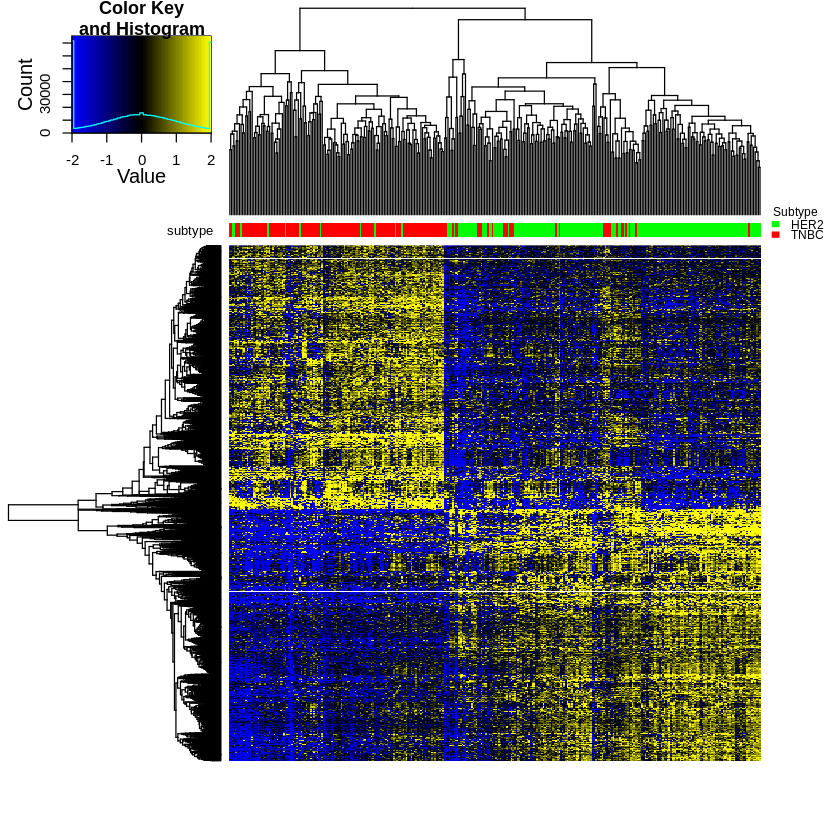

In [156]:
#To visualize our DESeq and filtering results, we need to create a matric of abundance (tpm) of all samples (HER2+/TNBC) 
#and all genes that are signifficantly different and pass filtering criteria
#remember her2.tpm.sig is unlogged tpm data we generated above from all her2 samples
#the same is true of tnbc.tpm.sig
#rownames of the results.sig.exp.fc are the genes that passed the filtering criteria
hm.her2.tpm.filtered <- her2.tpm.sig[rownames(results.sig.exp.fc), ]
hm.tnbc.tpm.filtered <- tnbc.tpm.sig[rownames(results.sig.exp.fc), ]
hm.tpm.filtered.combined <- cbind(hm.her2.tpm.filtered, hm.tnbc.tpm.filtered)

#for visualization purposes, tpm data is often better log2 transformed
hm.log.tpm <- log2(hm.tpm.filtered.combined + 0.001)

#likewise median centering the rows allows for easier visualization and interpration
row.medians <- rowMedians(as.matrix(hm.log.tpm))
hm.log.median.centered.tpm <- hm.log.tpm - row.medians

#we need to establish colors for her2 and tnbc to label the columns (samples) as we have too many 
# samples to read the names
#in this command we establish that green represents her2 and red tnbc
#we also establish how many her2 and tnbc samples there are using the rep command
colcolors <- cbind(subtype = c(rep("green", ncol(hm.her2.tpm.filtered)), rep("red", ncol(hm.tnbc.tpm.filtered))))

#next we need to establish what the colors in the heatmap represent and how many colors to use
#breaks establishes how many colors. in this case we go from -2 to 2 by 0.05.
#-2 and 2 were selected as they will show all samples greater than 4 fold from the median as dark colors
#samples closer to the median will have a duller color
#these numbers can be altered for best visualization purposes
breaks <- seq(-2, 2, by = 0.05)

#this command establishes what colors to use. In this example values around the median will be black
#higher than the median yellow, and lower than the median will be blue.
#the colorpanel command helps break all of the colors into different gradients based on the number of breaks
#note that you can change the colors
#also note that there are only so many different versions of each color
col<- colorpanel(n = length(breaks) - 1, low = "blue", mid = "black", high = "yellow")


#heatmap of filtered genes clustering both by gene and sample
#tpm data has to be a matrix
#ColSideColors establishes color for each column as defined in colcolors
#breaks and col are described and defined above
#note that because we have so many genes and samples the labels cannot be read, so we removed them with the labRow, LabCol options.

heatmap.3(as.matrix(hm.log.median.centered.tpm), ColSideColors = colcolors, breaks = breaks, col = col, dendrogram = "both", density.info = "histogram", labRow = FALSE, labCol = FALSE)
legend(x=0.96, y=0.84, xpd = TRUE, title = "Subtype", legend=c("HER2","TNBC"), fill=c("green","red"), border=FALSE, bty="n", cex=0.6, y.intersp = 0.7, inset = 0.1)
dev.off()



#heatmap.tpm.lncRNAs <- heatmap.3(as.matrix(df.genetpmbc.log.lncRNAs.combined.final), ColSideColors = colcolors.lncRNAs, breaks = breaks.lncRNAs, col = col.lncRNAs, Colv = FALSE, dendrogram = "row", density.info = "histogram")
#heatmap.tpm.lncRNAs.clustered <- heatmap.3(as.matrix(df.genetpmbc.log.lncRNAs.combined.final), ColSideColors = colcolors.lncRNAs, breaks = breaks.lncRNAs, col = col.lncRNAs, dendrogram = "both", density.info = "histogram")


## Now you make a heatmap of results.stringent
compare and contrast the two heatmaps.